# Homework 6 - Regression
In this guide, we will be exploring using regression as an intro to artificial intelligence. 
For this week's assignment, we will be exploring linear regression. We'll be using the data from our soccer database from assignment 4.

### Instructions
1. Follow the instructions on how to setup your Python and Jupyter (or VSCode) environment and cloning or downloading our repository. Instructions can be found in the class notes.
2. Import soccer database using pandas.
3. Load the values from the attributes `gk_reflexes` and `gk_handling` from table `Player_Attributes`.
4. Use `gk_reflexes` (as x) and `gk_handling` (as y) as your data.
5. Drop the missing values from these two columns.
6. Scale the dataset using a standard scaler.
7. Split the data into training and testing in a 0.3 ratio (70% training, 30% testing).
8. Apply Linear Regression, Cross-Validation (with 5 splits), Ridge Regularization, and Lasso Regularizations and print the co-relation result of each technique using `r2_score`. All of the functions for this last step are located in sklearn.
9. Answer the questions in the notebook through code.
10. Run the notebook and make sure everything works.
11. Export the notebook as HTML or PDF.
12. Submit the notebook through Canvas.

Remember to fill the missing pieces of code in the provided notebook.

### Dataset Overview
The dataset covers information about soccer players in sqlite format. This file is located in the `Datasets` directory of this repository. The file is called `fifa_soccer_dataset.sqlite.gz`. **This is the same file from the previous homework (assignment 4).**

If you haven't decompressed the file, you may need to follow the instructions below to decompress it.

**IMPORTANT** The database is compressed and needs to be decompressed before use. You can do this by running the following command in your terminal on Linux or MacOS:

```bash
gunzip Datasets/fifa_soccer_dataset.sqlite.gz
```

If you are using Windows, you can use the following command in your powershell:

```powershell
$sourceFile = "$PWD\Datasets\fifa_soccer_dataset.sqlite.gz"
$destinationFile = "$PWD\Datasets\fifa_soccer_dataset.sqlite"

$inputStream = [System.IO.File]::OpenRead($sourceFile)
$outputStream = [System.IO.File]::Create($destinationFile)
$gzipStream = New-Object System.IO.Compression.GzipStream($inputStream, [System.IO.Compression.CompressionMode]::Decompress)
$gzipStream.CopyTo($outputStream)

$gzipStream.Close()
$outputStream.Close()
$inputStream.Close()
```

Alternatively, you can extract the file using the GUI of your operating system.


### Submission Guidelines

- Submit your completed notebook as a HTML export, or a PDF file.

To export to HTML, if you are on Jupyter, select `File` > `Export Notebook As` > `HTML`.

If you are on VSCode, you can use the `Jupyter: Export to HTML` command.
 - Open the command palette (Ctrl+Shift+P or Cmd+Shift+P on Mac).
     - Search for `Jupyter: Export to HTML`.
     - Save the HTML file to your computer and submit it via Canvas.

---

To begin, we'll need quite a few imports.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import os

# Local directory
print(os.getcwd())

c:\Ricardo\2025-02 SP25 USABLE ARTIFICIAL INTELLIGENCE\GitHub\usable_ai\Homework


We're going to use the soccer data to run regressions. In the cell below, connect to the database.

In [2]:
# Input Code Here
dataset_path = "../Database/fifa_soccer_dataset.sqlite" # Fix your path accordingly

conn = sqlite3.connect(dataset_path)


In [3]:
# Using https://docs.python.org/3/library/sqlite3.html#sqlite3-tutorial

# Get the structure first
cur = conn.cursor()

# get all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
for table in tables:
    print(table)


('sqlite_sequence',)
('Player_Attributes',)
('Player',)
('Match',)
('League',)
('Country',)
('Team',)
('Team_Attributes',)
('stories',)
('information',)
('word_counts',)


To get started, let's write a query to grab all of the entries from the `Player_Attributes` table, and print the first 5 rows below.

In [4]:
# Input Code Here

player_attr_df = pd.read_sql("SELECT * FROM Player_Attributes;", conn)

# Display the first 5 rows of the table
display(player_attr_df.head(5))

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


We are going to play with two fields today, the `gk_handling` field as the dependent feature and the `gk_reflexes` field as the independent feature. Let's drop some missing values from these two columns as well. They represent the goalkeeping handling and reflexes of a player respectively.

In [5]:
# Before dropping
# Show count total and missing values for 'gk_handling' and 'gk_reflexes'
total_counts = player_attr_df[['gk_handling', 'gk_reflexes']].count()
missing_counts = player_attr_df[['gk_handling', 'gk_reflexes']].isnull().sum()

selected_columns_df = pd.DataFrame({'Total Values': total_counts, 'Missing Values': missing_counts})
display(selected_columns_df)

# Input Code Here - Drop null values from the mentioned columns
player_attr_df = player_attr_df.dropna(subset=['gk_handling', 'gk_reflexes'])

,Total Values,Missing Values
gk_handling,183142,836
gk_reflexes,183142,836


In [6]:
print("After dropping:")
# Show count total and missing values for 'gk_handling' and 'gk_reflexes'
total_counts = player_attr_df[['gk_handling', 'gk_reflexes']].count()
missing_counts = player_attr_df[['gk_handling', 'gk_reflexes']].isnull().sum()

selected_columns_df = pd.DataFrame({'Total Values': total_counts, 'Missing Values': missing_counts})
display(selected_columns_df)

After dropping:


,Total Values,Missing Values
gk_handling,183142,0
gk_reflexes,183142,0


Let's store those columns in their own variables for easy reading.

In [7]:
# Independent var gk_reflexes :: x
# Dependent var gk_handling :: y
x = player_attr_df[['gk_reflexes']].values # Input Code Here
y = player_attr_df[['gk_handling']].values # Input Code Here

To preform and evaluate our linear regression, we need to split our data into test and training batches. We can do this by using the `train_test_split()` function. In the cell below, use this function and pass it `x` and `y` as the data for it to split. The final parameter `test_size` indicates how big the test batch should be, in this case 30% of the initial dataset inputted.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3) #Input Code here

# Print size of each
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")
print(f"Y_train size: {Y_train.shape}")
print(f"Y_test size: {Y_test.shape}")

X_train size: (128199, 1)
X_test size: (54943, 1)
Y_train size: (128199, 1)
Y_test size: (54943, 1)


We can now preform the fitting. Let's call the `fit()` function on our `lm` variable, passing the `X_train` and `Y_train` data as parameters.

In [9]:
# Input Code Here
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

lm = LinearRegression()
reg = lm.fit(X = X_train, y = Y_train) 

display(reg)

LinearRegression()

Great! Now we can use the predict funtion to see how the model preforms against our test data set. Call the `predict()` function on `lm` and pass `X_test` as our input parameter. We'll then see the r2 score to see how correlated these values are. 

In [10]:
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
# r2_score(y_true, y_pred)

Y_predicted = lm.predict(X_test) # Input Code Here
rsquared = r2_score(Y_test, Y_predicted)
print("R2 Score: " + str(rsquared))

R2 Score: 0.9328855618120586


These values are pretty correlated! We can also use the `StandarScalar()` to transform our values before fitting our model. In the cell below, call the `StandardScalar()` function and pass `x` and `y` to the `fit_transform()` functions. 

In [11]:
sc = StandardScaler() # Input Code Here

x_scaled = sc.fit_transform(x) # Input Code Here
y_scaled = sc.fit_transform(y) # Input Code Here

Now we can run the model again as we did before. We'll need to split the training and test batches again, then run a new `fit()`. Once fitted, we can again use `predict()` and run a r2 score again.

In [12]:
# Input Code Here to split the scaled dataset

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y_scaled, test_size = 0.3) #Input Code here

# Print size of each
print("Scaled case:")
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")
print(f"Y_train size: {Y_train.shape}")
print(f"Y_test size: {Y_test.shape}")

Scaled case:
X_train size: (128199, 1)
X_test size: (54943, 1)
Y_train size: (128199, 1)
Y_test size: (54943, 1)


In [13]:
# Input Code Here to create and fit the model

lm = LinearRegression()
reg = lm.fit(X = X_train, y = Y_train) 

display(reg)

LinearRegression()

In [14]:
Y_predicted = lm.predict(X_test) # Input Code Here
# Input Code Here - Grab the R2 Score like we did above
rsquared = r2_score(Y_test, Y_predicted)
print("R2 Score: " + str(rsquared))

R2 Score: 0.9338956849702866


Implementing various models - LinearRegression(), Ridge(), Lasso() along with K-Fold CrossValidation with 5 splits.
Use the unscaled data for this step.

In [34]:
# Back to unscaled data

# Independent var gk_reflexes :: x
# Dependent var gk_handling :: y
x = player_attr_df[['gk_reflexes']].values # Input Code Here
y = player_attr_df[['gk_handling']].values # Input Code Here

print("x len:", len(x))

# Per discussion with Professor Silva 03-25 - use all x, y data
# X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3) #Input Code here

# Apply Linear regression, ridge regularization, lasso regularization with cross validation

# Define models
model_lr = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()

# Cross validation
kf = KFold(n_splits = 5)
list_r2_score = [] # to keep the r2 score

# Split the train set:
for train_index, test_index in kf.split(x):
    print("train_index:",len(train_index),f"{len(train_index)/len(x):.2f}", "test_index",len(test_index),f"{len(test_index)/len(x):.2f}")
    X_train_fold, X_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    k_fold_r2 = []
    for model in [model_lr, model_ridge, model_lasso]:
        model.fit(X_train_fold, y_train_fold) # Training the model
        pred = model.predict(X_test_fold) # Predictions
        k_fold_r2.append(r2_score(y_test_fold, pred))
    
    list_r2_score.append(k_fold_r2)
    
# Show the result - Add Mean and Standard Deviation of the R2-scores
list_r2_score.append(list(np.mean(list_r2_score, axis = 0)))
list_r2_score.append(list(np.std(list_r2_score[:-1], axis = 0)))

result_r2 = pd.DataFrame(list_r2_score)
result_r2.columns = ['Linear Regression', 'Ridge', 'Lasso']
result_r2.index = ['k1', 'k2', 'k3', 'k4', 'k5', 'average', 'std']

print('The result of r2 scores for k=5 cross validation')
display(result_r2)

x len: 183142
train_index: 146513 0.80 test_index 36629 0.20
train_index: 146513 0.80 test_index 36629 0.20
train_index: 146514 0.80 test_index 36628 0.20
train_index: 146514 0.80 test_index 36628 0.20
train_index: 146514 0.80 test_index 36628 0.20
The result of r2 scores for k=5 cross validation


,Linear Regression,Ridge,Lasso
k1,0.932690,0.932690,0.932701
k2,0.928483,0.928483,0.928453
k3,0.932024,0.932024,0.932009
k4,0.931913,0.931913,0.931927
k5,0.942354,0.942354,0.942310
average,0.933493,0.933493,0.933480
std,0.004667,0.004667,0.004657


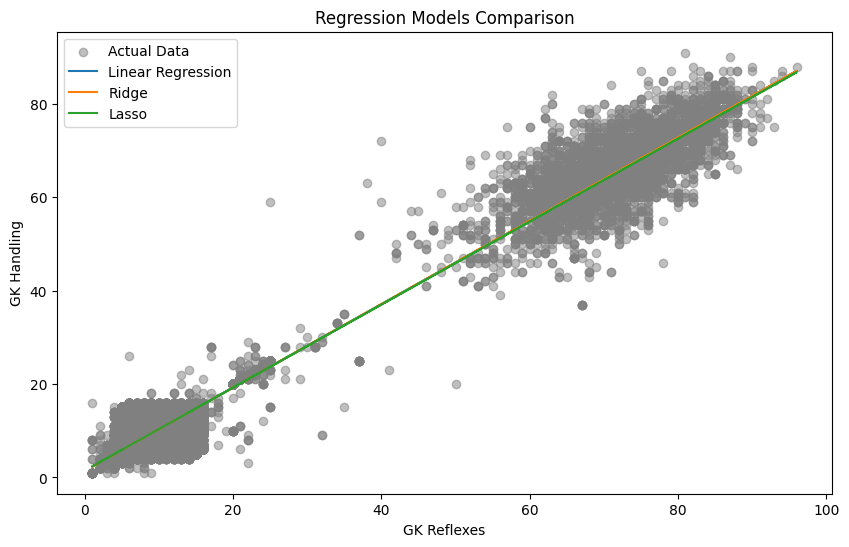

In [18]:
import matplotlib.pyplot as plt

# Train models
models = {'Linear Regression': model_lr, 'Ridge': model_ridge, 'Lasso': model_lasso}
predictions = {}

plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(X_test, Y_test, color='gray', alpha=0.5, label="Actual Data")

# Fit and predict for each model
for name, model in models.items():
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    predictions[name] = pred
    plt.plot(X_test, pred, label=name)

# Plot settings
plt.xlabel("GK Reflexes")
plt.ylabel("GK Handling")
plt.title("Regression Models Comparison")
plt.legend()
plt.show()

And that's basic linear regression with python. Please turn in this notebook completed with your outputs displayed in html or pdf formats.